This file is best viewed here:

https://nbviewer.jupyter.org/github/zendry13/World-Happiness-Report-Visual-Analysis/blob/master/Project%207%20-%20Happiness%20Score.ipynb

GitHub does not display Plotly plots as it can only perform a static render of notebooks. The link above will allow you to view the violin and bubble plots. 

Dataset: https://www.kaggle.com/unsdsn/world-happiness 

The World Happiness Report assigned a happiness score to 156 countries by how happy their citizens perceive themselves to be. The score is calculated using the sum of each of the following variables: 

- Economy: real GDP per capita

- Family: social support

- Health: healthy life expectancy

- Freedom: freedom to make life choices

- Trust: perceptions of corruption

- Generosity: perceptions of generosity

- Dystopia: each country is compared against a hypothetical nation that represents the lowest national averages for each key variable and is, along with residual error, used as a regression benchmark

Final score is a population-weighted average score between 0 and 10. 

My goal is to explore how each variable contributes to the final score and the differences in score between each regions. 

# Initial Setup

In [1]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot 
import warnings

init_notebook_mode(connected=True)
pd.set_option('display.max_columns', None) 
from ipywidgets import interact, interactive, interact_manual
import ipywidgets as widgets
import colorlover as cl 


color = sns.color_palette()

import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999


Please put the 'happiness.csv' file in the same directory as the Jupyter notebook if you wish to use this code. 

In [2]:
# reading data
data = pd.read_csv('happiness.csv', index_col=0)

data.head()

,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
0,Afghanistan,Southern Asia,153.0,3.575,0.31982,0.30285,0.30335,0.23414,0.09719,0.36510,1.95210,2015
1,Albania,Central and Eastern Europe,95.0,4.959,0.87867,0.80434,0.81325,0.35733,0.06413,0.14272,1.89894,2015
2,Algeria,Middle East and Northern Africa,68.0,5.605,0.93929,1.07772,0.61766,0.28579,0.17383,0.07822,2.43209,2015
3,Angola,Sub-Saharan Africa,137.0,4.033,0.75778,0.86040,0.16683,0.10384,0.07122,0.12344,1.94939,2015
4,Argentina,Latin America and Caribbean,30.0,6.574,1.05351,1.24823,0.78723,0.44974,0.08484,0.11451,2.83600,2015


In [3]:
# sort df - ascending years, descending happiness scores
# make permanent change to data with inplace = True 
data.sort_values(['Year', "Happiness Score"], ascending=[True,False],inplace=True)
data.head()

,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
141,Switzerland,Western Europe,1.0,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015
60,Iceland,Western Europe,2.0,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015
38,Denmark,Western Europe,3.0,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015
108,Norway,Western Europe,4.0,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2015
25,Canada,North America,5.0,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,2015


Some basic questions to ask are: 

(a) What countries are happiest? How do regions within countries varying in happiness? 

(b) How does it correlate with economy, family, health, freedom, etc.? 

(c) How does scorer fluctuate over many years? 

In [4]:
print("Data has {0} rows and {1} columns".format(data.shape[0],data.shape[1]))

Data has 495 rows and 12 columns


In [5]:
# check missing values 
data.isna().sum()

Country                           0
Region                            0
Happiness Rank                   25
Happiness Score                  25
Economy (GDP per Capita)         25
Family                           25
Health (Life Expectancy)         25
Freedom                          25
Trust (Government Corruption)    25
Generosity                       25
Dystopia Residual                25
Year                              0
dtype: int64

In [6]:
# drop missing values
data.dropna(inplace=True)

In [7]:
# double check for missing values
data.isna().sum()

Country                          0
Region                           0
Happiness Rank                   0
Happiness Score                  0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Dystopia Residual                0
Year                             0
dtype: int64

In [8]:
data.describe()

,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
count,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000
mean,78.829787,5.370728,0.927830,0.990347,0.579968,0.402828,0.134790,0.242241,2.092717,2015.993617
std,45.281408,1.136998,0.415584,0.318707,0.240161,0.150356,0.111313,0.131543,0.565772,0.816907
min,1.000000,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328580,2015.000000
25%,40.000000,4.509000,0.605292,0.793000,0.402301,0.297615,0.059777,0.152831,1.737975,2015.000000
50%,79.000000,5.282500,0.995439,1.025665,0.630053,0.418347,0.099502,0.223140,2.094640,2016.000000
75%,118.000000,6.233750,1.252443,1.228745,0.768298,0.516850,0.173161,0.315824,2.455575,2017.000000
max,158.000000,7.587000,1.870766,1.610574,1.025250,0.669730,0.551910,0.838075,3.837720,2017.000000


In [9]:
data_c = data.copy()

# Analyzing Score by Region and Year

In [10]:
# Quick Overview of Just One Column 
data_c.pivot_table(index='Region', values='Happiness Score').sort_values('Happiness Score', ascending=False)

,Happiness Score
Region,
Australia and New Zealand,7.302500
North America,7.227167
Western Europe,6.693000
Latin America and Caribbean,6.069074
Eastern Asia,5.632333
Middle East and Northern Africa,5.387879
Central and Eastern Europe,5.371184
Southeastern Asia,5.364077
Southern Asia,4.590857


Let's look at groupby and pivot_table versions based on Region and Year. 

In [11]:
# groupby version of Region, aggregate mean 
# df.groupby('grouping column').agg({'aggregating column': 'aggregating function'})

data_c.groupby(['Region','Year']).agg({'Happiness Score': 'mean'}).round(3).head(10)

# note this is equivalent:
# pd.pivot_table(data_c, index=['Region','Year'], values='Happiness Score', aggfunc='mean').head(10)

Happiness Score
Region                      Year                 
Australia and New Zealand   2015            7.285
                            2016            7.323
                            2017            7.299
Central and Eastern Europe  2015            5.333
                            2016            5.371
                            2017            5.410
Eastern Asia                2015            5.626
                            2016            5.624
                            2017            5.647
Latin America and Caribbean 2015            6.145

In [12]:
# pivot table version 
# note if you use *multiple columns parameter, you can't see what you applied aggfunc on (happiness score)
# you also can't sort_values by happiness due to table position, though you can alphabetically rearrange region

data_c.pivot_table(index='Region', columns='Year', values='Happiness Score', aggfunc=np.mean)

Year,2015,2016,2017
Region,,,
Australia and New Zealand,7.285000,7.323500,7.299000
Central and Eastern Europe,5.332931,5.370690,5.409931
Eastern Asia,5.626167,5.624167,5.646667
Latin America and Caribbean,6.144682,6.101750,5.957818
Middle East and Northern Africa,5.406900,5.386053,5.369684
North America,7.273000,7.254000,7.154500
Southeastern Asia,5.317444,5.338889,5.444875
Southern Asia,4.580857,4.563286,4.628429
Sub-Saharan Africa,4.202800,4.136421,4.111949


Scores are very consistent year to year, with fairly low variance. Biggest fluctuation is in Central and Eastern Europe. 

We could also check the standard deviation within regions. 

In [13]:
data_c.pivot_table(index='Region', values='Happiness Score', aggfunc=[np.mean, np.median, min, max, np.std])

,mean,median,min,max,std
,Happiness Score,Happiness Score,Happiness Score,Happiness Score,Happiness Score
Region,,,,,
Australia and New Zealand,7.302500,7.2995,7.284,7.334,0.020936
Central and Eastern Europe,5.371184,5.4010,4.096,6.609,0.578274
Eastern Asia,5.632333,5.6545,4.874,6.422,0.502100
Latin America and Caribbean,6.069074,6.1265,3.603,7.226,0.728157
Middle East and Northern Africa,5.387879,5.3175,3.006,7.278,1.031656
North America,7.227167,7.2175,6.993,7.427,0.179331
Southeastern Asia,5.364077,5.2965,3.819,6.798,0.882637
Southern Asia,4.590857,4.6080,3.360,5.269,0.535978


Western Europe is surprisingly not at the top of the list, despite the high averages of Nordic countries. It would be interesting to see which countries are weighing down the averages.  

North America has an unusually low standard deviation. Australia and New Zealand are to be expected, given that they're isolated regions and close together.  

The standard deviation of Middle East and Northern Africa in particular is very high . This indicates sub-regions range from low scores to high scores - also supported by the min and max. 

## Western Europe 

Let's look specifically at 2015 and for Western Europe. 

In [14]:
# order to see which counries have a lower score in Western Europe
data_c[(data_c['Region']== 'Western Europe') & (data_c['Year']==2015)]

,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
141,Switzerland,Western Europe,1.0,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015
60,Iceland,Western Europe,2.0,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015
38,Denmark,Western Europe,3.0,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015
108,Norway,Western Europe,4.0,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2015
46,Finland,Western Europe,6.0,7.406,1.29025,1.31826,0.88911,0.64169,0.41372,0.23351,2.61955,2015
102,Netherlands,Western Europe,7.0,7.378,1.32944,1.28017,0.89284,0.61576,0.31814,0.47610,2.46570,2015
140,Sweden,Western Europe,8.0,7.364,1.33171,1.28907,0.91087,0.65980,0.43844,0.36262,2.37119,2015
7,Austria,Western Europe,13.0,7.200,1.33723,1.29704,0.89042,0.62433,0.18676,0.33088,2.53320,2015
84,Luxembourg,Western Europe,17.0,6.946,1.56391,1.21963,0.91894,0.61583,0.37798,0.28034,1.96961,2015
65,Ireland,Western Europe,18.0,6.940,1.33596,1.36948,0.89533,0.61777,0.28703,0.45901,1.97570,2015


Prominent countries that score between 6-7 are Spain, Germany, United Kingdom, Ireland, and France. 

Below 6 are Italy, Cyprus, Greece, and Portugal. 

Tiers can be made based on happiness rank: 1st tier (top 8), 2nd tier (next 8), and 3rd tier (bottom 5).

In [15]:
# # Mean of the top 8 countries in Western Europe
# top8 = data_c[(data_c['Region']== 'Western Europe') & (data_c['Year']==2015)].iloc[0:8]
# top8.mean()

# # Mean of the middle 8 
# middle8 = data_c[(data_c['Region']=='Western Europe') & (data_c['Year']==2015)].iloc[8:16]
# middle8.mean()

# # Mean of the bottom 8
# bottom8 = data_c[(data_c['Region']=='Western Europe') & (data_c['Year']==2015)].iloc[-5:]
# bottom8.mean()

# w_europe = pd.concat(:[top8, middle8, bottom8], axis=0).reset_index()

# Visualization

## Bar Graph
Rather than looking at data frames, we can look at bar graph representation of regions and years. 

Text(0, 0.5, 'Happiness Rank')

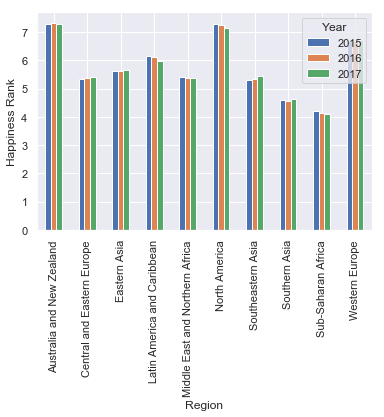

In [16]:
sns.set()

# data_c.groupby(['Region','Year']).agg({'Happiness Score': 'mean'}).plot(kind='bar')
# plt.ylabel("Happiness Rank")
# groupby plotEx

data_c.pivot_table(index='Region', columns='Year',values='Happiness Score', aggfunc='mean').plot(kind='bar')
plt.ylabel("Happiness Rank")

This indicates that from year to year, the data is very consistent. 

## Violin Graph
Let's now look at violin graphs, which are my favorite ways to look at statistics involving mean, median, outliers,and standard deviation. 

In [17]:
# violin plot
# kde = kernel density estimation, width of violin 

data = []
for i in data_c['Region'].unique():
    trace = {
            "type": 'violin',
            "x": data_c.loc[(data_c['Region'] == i), 'Region'],
            "y": data_c.loc[(data_c['Region'] == i), 'Happiness Score'],
            "name": i,
            "meanline": {
                "visible": True
            }
        }
    data.append(trace)
    
            
fig = {
    "data": data,
    "layout" : {
        "title": "",
        "yaxis": {
            "zeroline": False,
        }
    }
}

fig['layout'].update(title= 'Happiness Score Across Regions');
iplot(fig)

The violin graph is a fantastic visualization tool - once you get used to it - because it illustrates not only the usual quartiles, median/mean, and max/min (like a box plot) but also the kernel density estimator represented by the width of the 'violin'. The width - kde - indicates the density of distribution. Typically most things are distributed around the mean, giving most graphs a violin shape. 



With the violin graph, it's immediately clear that even countries with very high peaks like Western Europe, Middle East & Northern Africa, and Southeastern Asia tend to have incredibly low peaks as well. But it also easily highlights what's the norm. For instance, looking at the violin width indicates that the vast majority for Western Europe will score 7 or higher on happiness.  

## Scatterplot 
One thing worth looking at is the correlation between the happiness score variables like life expectancy and economy. A simple scatter plot reflect this. 

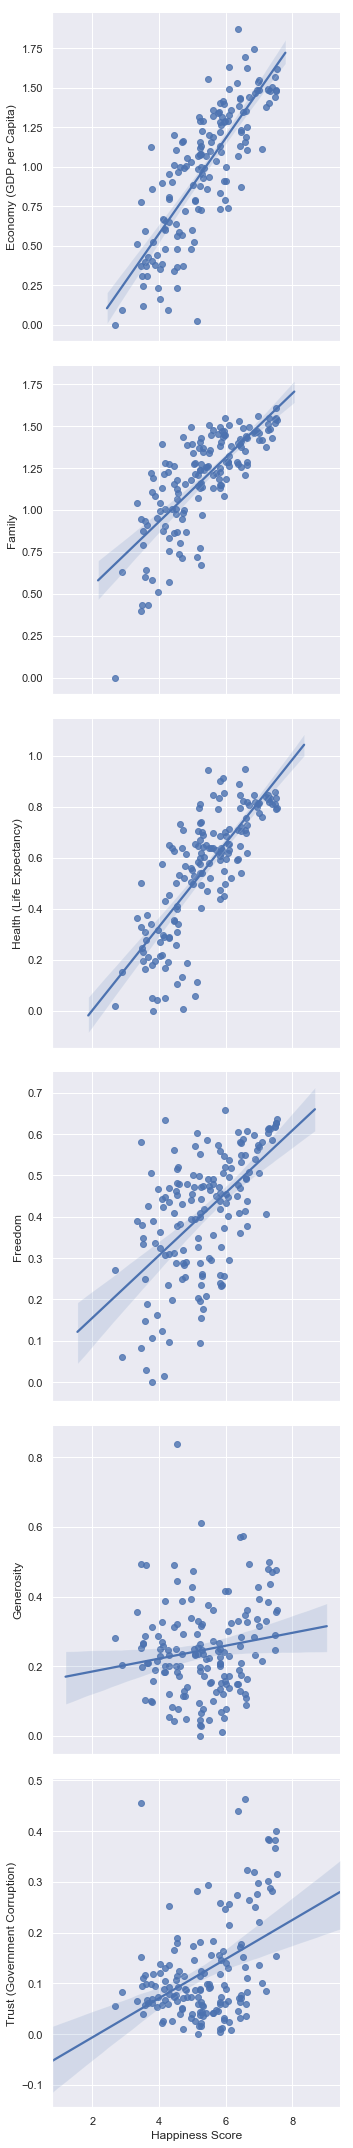

In [18]:
sns.pairplot(data=data_c[data_c['Year']==2017],kind='reg',height=5, x_vars=['Happiness Score'], y_vars=['Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Generosity','Trust (Government Corruption)']) 

Based on the criteria for what 'happiness' entails, it's obvious there will always be a positive correlation. What isn't so clear is that some variables between countries have greater impact than others. If we look at generosity and government trust for instance, these do not weigh heavily as family, economy, health, and freedom. 

In [19]:
data_c[data_c['Year']==2017].corr(method="pearson", min_periods=20)["Happiness Score"].sort_values(ascending=False)

Happiness Score                  1.000000
Economy (GDP per Capita)         0.812469
Health (Life Expectancy)         0.781951
Family                           0.752737
Freedom                          0.570137
Dystopia Residual                0.475355
Trust (Government Corruption)    0.429080
Generosity                       0.155256
Happiness Rank                  -0.992774
Year                                  NaN
Name: Happiness Score, dtype: float64

But it's interesting that the correlation will change greatly depending on the region. For instance, let's look at Western Europe. 

In [20]:
data_c[data_c['Region']=='Western Europe'].corr(method="pearson", min_periods=20)["Happiness Score"].sort_values(ascending=False)

Happiness Score                  1.000000
Trust (Government Corruption)    0.833500
Freedom                          0.796336
Dystopia Residual                0.734505
Economy (GDP per Capita)         0.596955
Generosity                       0.595061
Family                           0.501688
Year                             0.007457
Health (Life Expectancy)        -0.024186
Happiness Rank                  -0.988021
Name: Happiness Score, dtype: float64

Perhaps this is because even poorly ranked countries in Western Europe region also tend to do relatively well in health and economy. My conjecture is once you get to a certain threshold, other things start to get prioritized and valued, such as trust and freedom. 

In fact, economy, health, and family are in their own tier in terms of impacting the happiness score. This is because a factor like lack of trust is fairly ubiquitous but there are still enormous gaps in economy and health between first world countries and third world counterparts. 

## Bubble Plot 

A bubble plot can show three variables rather than the tyical 2 of a scatterplot and how these variables correlate with one another. One of the variable I'll be using is the happiness rank, so that we can see how the rank - as measured by the size of the bubble - correlates with the economy and life expectancy. 

In [21]:
from bubbly.bubbly import bubbleplot 


figure = bubbleplot(dataset=data_c[data_c['Region']=='Western Europe'], x_column='Freedom', y_column='Trust (Government Corruption)', 
    bubble_column='Country', time_column='Year', size_column='Happiness Rank', color_column='Country', 
    x_title="Freedom", y_title="Trust", title='Bubble Plot',
    x_logscale=False, y_logscale=True, scale_bubble=0.3, height=750)

iplot(figure)

The size of the bubble indicates the happiness rank - lower the rank, the higher the happiness score. I choose rank over score to separate the bubbles more. But keep in mind that smaller the bubble, the higher the score. 

Let's now look at correlations that were surprisingly weak (e.g health and economy).  

In [22]:
from bubbly.bubbly import bubbleplot 
#np.seterr(divide = 'ignore') 

figure = bubbleplot(dataset=data_c[data_c['Region']=='Western Europe'], x_column='Economy (GDP per Capita)', y_column='Health (Life Expectancy)', 
    bubble_column='Country', time_column='Year', size_column='Happiness Rank', color_column='Country', 
    x_title="GDP per Capita", y_title="Life Expectancy", title='Bubble Plot',
    x_logscale=True, y_logscale=True, scale_bubble=0.3, height=650)

iplot(figure) 

As expected, the bubbles are all over the place due to the weakness of the correlation. 